In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, ttest_1samp
import psycopg2
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sqlalchemy import create_engine 
import os
from dotenv import load_dotenv
load_dotenv("../../.env.postgres")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
conn = psycopg2.connect(
    database = "amazon_uk",
    user = os.environ["POSTGRES_USER"],
    password = os.environ["POSTGRES_PASSWORD"]
)

In [3]:
df = pd.read_sql("SELECT * FROM amazon_uk_2023_health_personal_care;", conn)
df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_11144\1004047796.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM amazon_uk_2023_health_personal_care;", conn)


,index,asin,title,imgUrl,productURL,stars,reviews,price,isBestSeller,boughtInLastMonth,categoryName
0,1255627,B0014SEMQK,"Blue Stratos, PreElectric, 100 ml",https://m.media-amazon.com/images/I/612ddjkWuH...,https://www.amazon.co.uk/dp/B0014SEMQK,4.4,1822,7.59,False,600,Health & Personal Care
1,1256677,B00B8ZM5KY,Durex Intense Delight Vibrating Bullet Sex Toy,https://m.media-amazon.com/images/I/71Od5ubIuP...,https://www.amazon.co.uk/dp/B00B8ZM5KY,4.2,4054,8.40,False,700,Health & Personal Care
2,1252762,B00I5KPYFS,"COLOR WOW Raise The Root, 150 ml",https://m.media-amazon.com/images/I/51-EbjxYEO...,https://www.amazon.co.uk/dp/B00I5KPYFS,4.1,1037,13.99,False,2000,Health & Personal Care
3,1252787,B000N0SNHY,"Dr. Brown's Bottle and Teat Brush, Blue",https://m.media-amazon.com/images/I/51Su0t6gCw...,https://www.amazon.co.uk/dp/B000N0SNHY,4.5,31293,5.49,False,3000,Health & Personal Care
4,1252380,B0010YNW6E,"Full Marks Solution 4 Treatments, to Kill Head...",https://m.media-amazon.com/images/I/71pMwgwyrV...,https://www.amazon.co.uk/dp/B0010YNW6E,4.5,4459,9.00,False,7000,Health & Personal Care


In [4]:
conn.close()

In [5]:
conn_string = os.environ.get("POSTGRES_CONN")
conn = create_engine(conn_string)

Analyze the statistics

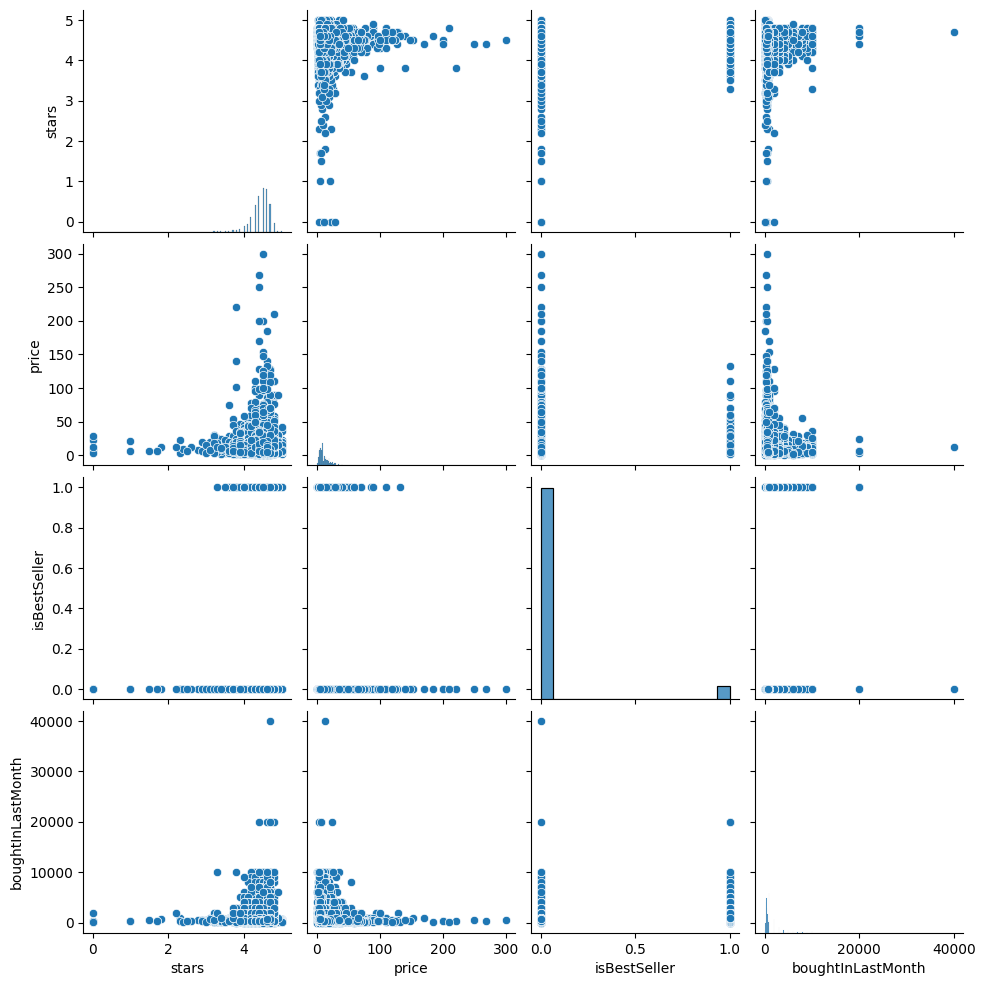

In [6]:
sns.pairplot(df[["stars", "price", "isBestSeller", "boughtInLastMonth"]])

In [7]:
df[df["boughtInLastMonth"] > 1000].shape[0] / df.shape[0]

0.13224043715846995

In [8]:
df["moreBought"] = df["boughtInLastMonth"] > 1000

<Axes: xlabel='moreBought', ylabel='stars'>

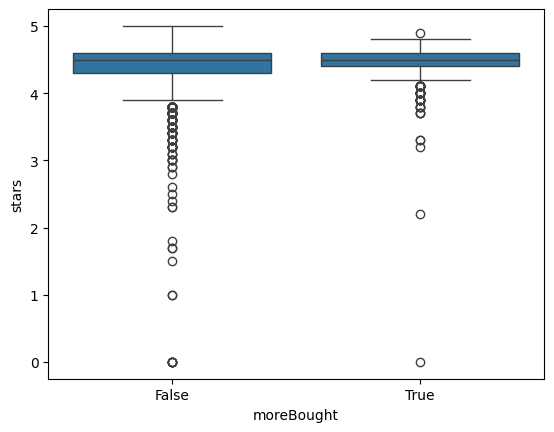

In [9]:
sns.boxplot(df, x = "moreBought", y = "stars")

<Axes: xlabel='moreBought', ylabel='price'>

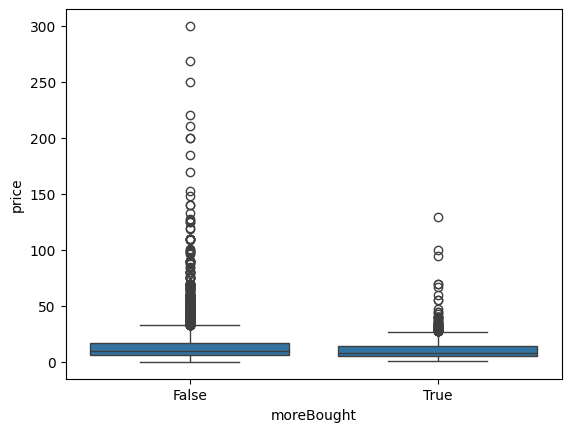

In [10]:
sns.boxplot(df, x = "moreBought", y = "price")

In [11]:
# t-test for means of Stars between 2 groups
stars_more_bought = np.array(df[df["moreBought"]]["stars"])
stars_less_bought = np.array(df[~df["moreBought"]]["stars"])
t_test_res = ttest_ind(stars_more_bought, stars_less_bought, equal_var = False)
print("Result for Welch's t-test for difference in means of stars ratings of more bought vs. less bought group")
print(f"t-statistics: {t_test_res.statistic}")
print(f"p-value: {t_test_res.pvalue}")
ci = t_test_res.confidence_interval()
print("CI for difference in means of star ratings of more bought vs. less bought group")
print(f"({ci.low}, {ci.high})")

Result for Welch's t-test for difference in means of stars ratings of more bought vs. less bought group
t-statistics: 9.524536136546224
p-value: 5.876740073767178e-21
CI for difference in means of star ratings of more bought vs. less bought group
(0.06388006731956204, 0.09701396575216718)


In [12]:
# t-test for means of Stars between 2 groups
price_more_bought = np.array(df[df["moreBought"]]["price"])
price_less_bought = np.array(df[~df["moreBought"]]["price"])
t_test_res = ttest_ind(price_more_bought, price_less_bought, equal_var = False)
print("Result for Welch's t-test for difference in means of price of more bought vs. less bought group")
print(f"t-statistics: {t_test_res.statistic}")
print(f"p-value: {t_test_res.pvalue}")
ci = t_test_res.confidence_interval()
print("CI for difference in means of price of more bought vs. less bought group")
print(f"({ci.low}, {ci.high})")

Result for Welch's t-test for difference in means of price of more bought vs. less bought group
t-statistics: -7.4246837673623745
p-value: 1.7236949235807082e-13
CI for difference in means of price of more bought vs. less bought group
(-3.2472696062349176, -1.8901884411498582)


In [13]:
t_test_res = ttest_1samp(np.array(df["price"]), 0)
ci = t_test_res.confidence_interval()
print("CI for means of price of Health & Personal Care product")
print(f"({ci.low}, {ci.high})")

CI for means of price of Health & Personal Care product
(12.97872469231607, 13.570832077568568)


Prices are pretty much the same, but higher ratings + higher bought? Why can this happen

In [14]:
# plot words from products that has someone bought
more_bought_df = df[df["moreBought"]]
more_bought_title_all = " ".join(more_bought_df["title"]).lower()
# Preprocess to remove non alphabet character and excess spaces
more_bought_title_all = re.sub(r'[^a-zA-Z\s]', '', more_bought_title_all)
more_bought_title_all = re.sub(r'\s+', ' ', more_bought_title_all).strip()
# Get all words
more_bought_title_words = more_bought_title_all.split()
# remove stopwords
more_bought_title_words = [w for w in more_bought_title_words if w not in stop_words]
# Set up counter
more_bought_title_words_counter = {}
for w in more_bought_title_words:
    more_bought_title_words_counter[w] = more_bought_title_words_counter.get(w, 0) + 1
# Make the dataframe for this
more_bought_title_words_counter_t = {"word": [], "count": []}
for w in more_bought_title_words_counter:
    more_bought_title_words_counter_t["word"].append(w)
    more_bought_title_words_counter_t["count"].append(more_bought_title_words_counter[w])
more_bought_title_words_df = pd.DataFrame(more_bought_title_words_counter_t)
more_bought_title_words_df = more_bought_title_words_df.sort_values("count", ascending = False).reset_index().drop("index", axis = 1)
more_bought_title_words_df.head()

,word,count
0,ml,292
1,pack,287
2,hair,271
3,tablets,182
4,relief,125


In [15]:
# plot words from products that no one bought
less_bought_df = df[~df["moreBought"]]
less_bought_title_all = " ".join(less_bought_df["title"]).lower()
# Preprocess to remove non alphabet character and excess spaces
less_bought_title_all = re.sub(r'[^a-zA-Z\s]', '', less_bought_title_all)
less_bought_title_all = re.sub(r'\s+', ' ', less_bought_title_all).strip()
# Get all words
less_bought_title_words = less_bought_title_all.split()
# remove stopwords
less_bought_title_words = [w for w in less_bought_title_words if w not in stop_words]
# Set up counter
less_bought_title_words_counter = {}
for w in less_bought_title_words:
    less_bought_title_words_counter[w] = less_bought_title_words_counter.get(w, 0) + 1
# Make the dataframe for this
less_bought_title_words_counter_t = {"word": [], "count": []}
for w in less_bought_title_words_counter:
    less_bought_title_words_counter_t["word"].append(w)
    less_bought_title_words_counter_t["count"].append(less_bought_title_words_counter[w])
less_bought_title_words_df = pd.DataFrame(less_bought_title_words_counter_t).sort_values("count", ascending = False).reset_index().drop("index", axis = 1)
less_bought_title_words_df.head()

,word,count
0,hair,2353
1,ml,1611
2,pack,1486
3,men,777
4,x,777


In [16]:
only_more_bought = more_bought_title_words_df.merge(less_bought_title_words_df, how = "left", on = "word")
only_more_bought = only_more_bought[only_more_bought["count_y"].isna()]
only_more_bought

,word,count_x,count_y
702,combi,5,NaN
920,otex,4,NaN
950,hygienically,3,NaN
956,gets,3,NaN
1073,germoloids,3,NaN
...,...,...,...
3410,fluorigard,1,NaN
3411,minthy,1,NaN
3412,sleepeze,1,NaN
3415,kill,1,NaN


In [17]:
only_less_bought = less_bought_title_words_df.merge(more_bought_title_words_df, how = "left", on = "word")
only_less_bought = only_less_bought[only_less_bought["count_y"].isna()]
only_less_bought

,word,count_x,count_y
131,sex,128,NaN
277,accessories,69,NaN
316,vape,62,NaN
383,wella,53,NaN
390,grip,52,NaN
...,...,...,...
11191,padswith,1,NaN
11192,himala,1,NaN
11193,peppermintoil,1,NaN
11194,oligosaccharide,1,NaN


In [18]:
# Save these notable words data to postgres
only_more_bought = only_more_bought[["word", "count_x"]]
only_more_bought = only_more_bought.rename({"count_x": "count"}, axis = 1)
only_more_bought = only_more_bought.reset_index().drop("index", axis = 1)
only_more_bought.to_sql("amazon_uk_2023_care_product_more_bought_word", conn, if_exists = "replace")

473

In [19]:
# Save these notable words data to postgres
only_less_bought = only_less_bought[["word", "count_x"]]
only_less_bought = only_less_bought.rename({"count_x": "count"}, axis = 1)
only_less_bought = only_less_bought.reset_index().drop("index", axis = 1)
only_less_bought.to_sql("amazon_uk_2023_care_product_less_bought_word", conn, if_exists = "replace")

251